

# 使用``torch.autograd``进行自动微分
在训练神经网络时，最常用的算法是 **反向传播**。在这种算法中，参数是根据损失函数相对于给定参数的**梯度**来调整的。

为了计算这些梯度，PyTorch 内置了一个名为 ``torch.autograd`` 的微分引擎。它支持为任何计算图自动计算梯度。

比如最简单的单层神经网络，其输入为 ``x``，参数为 ``w` 和 ``b``，还有一些损失函数。它可以在 PyTorch 中通过如下方式定义：

In [1]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## 张量，函数和计算图

This code defines the following **computational graph**:
上述代码定义了如下形式的**计算图**

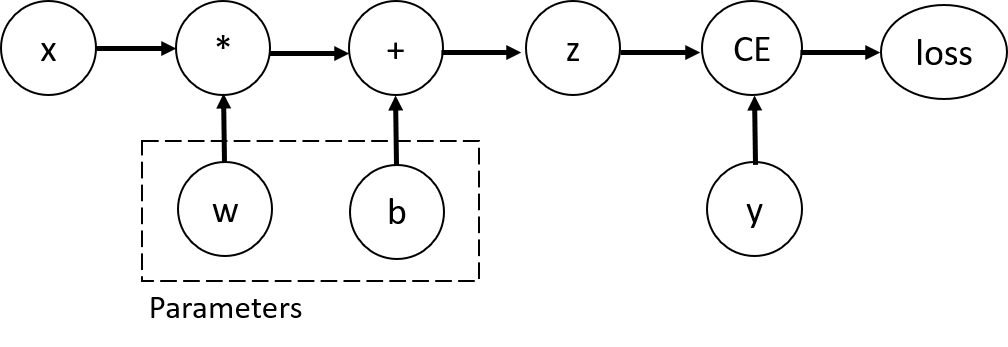

在这个网络中，``w`` 和 ``b`` 是我们需要优化的**参数**。因此，我们需要计算损失函数相对于这些变量的梯度。我们设置这些张量的 ``requires_grad`` 属性。


### Note

你可以在定义矩阵的时候使用``requires_grad``或者在之后使用``x.requires_grad_(True)``来定义矩阵属性。



我们应用于张量的用于构建计算图的函数，实际上是``Function``类的对象。这个对象知道如何在*正向*方向上计算函数，以及如何在*反向传播*步骤中计算其导数。对反向传播函数的引用存储在张量的``grad_fn``属性中。


In [2]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x1055dc2b0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x1055dc490>


## 计算梯度


为了优化神经网络中的参数权重，我们需要计算损失函数相对于参数的导数，即在一些固定的``x``和``y``值下，我们需要$\frac{\partial loss}{\partial w}$和$\frac{\partial loss}{\partial b}$。为了计算这些导数，我们调用``loss.backward()``，然后从``w.grad``和``b.grad``中调用这些值：



In [3]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2765, 0.0408, 0.0772],
        [0.2765, 0.0408, 0.0772],
        [0.2765, 0.0408, 0.0772],
        [0.2765, 0.0408, 0.0772],
        [0.2765, 0.0408, 0.0772]])
tensor([0.2765, 0.0408, 0.0772])



### Note

我们只能获得计算图中叶节点的``grad``属性，这些叶节点的``requires_grad``属性设置为``True``。对于图中的所有其他节点，梯度是获取不到的。

- 出于性能原因，PyTorch只能在给定的图上执行一次``backward``梯度计算。如果我们需要在同一图上执行多次``backward``调用，需要在``backward``调用中传递``retain_graph=True``。




## 禁用梯度追踪


默认情况下，所有具有``requires_grad=True``的张量都会跟踪它们的计算历史并支持梯度计算。然而，在某些情况下，我们不需要计算梯度，即我们只想通过网络执行*正向*计算。我们可以通过将计算代码放在``torch.no_grad()``代码块中来停止梯度的跟踪计算：



In [4]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False



另一种禁用梯度的方式是在张量上使用``detach()``



In [5]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False



禁用梯度跟踪的场景：
- 将神经网络中的某些参数标记为**冻结参数**。
- 在不跟踪梯度的张量上的计算会更高效。


## 深入计算图


从概念上讲，autograd 在一个有向无环图（DAG）中保留了数据（张量）以及所有执行过的操作（以及生成的新张量），这个DAG由[Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)对象组成。在这个DAG中，叶子节点是输入张量，根节点是输出张量。通过从根节点到叶子节点追踪这个图，可以自动使用链式规则计算梯度。

在前向传播中，autograd 同时执行两个操作：

- 运行请求的操作以计算结果张量
- 在DAG中维护操作的*梯度函数*。

当在DAG根节点上调用``.backward()``时，反向传播开始。然后，``autograd``执行以下操作：

- 从每个``.grad_fn``计算梯度，
- 在相应张量的``.grad``属性中累积它们
- 使用链式规则，将梯度一直传播到叶子张量。


<div class="alert alert-info"><h4>Note</h4><p>**在PyTorch中，DAGs是动态的**
需要注意的是，图每次都会从头开始重新创建；在每个``.backward()``调用之后，autograd都会开始填充一个新的图。这正是允许我们在模型中使用控制流语句的原因；如果需要，可以在每次迭代中更改形状、大小和操作。</p></div>

--------------




### 深入阅读
- [Autograd Mechanics](https://pytorch.org/docs/stable/notes/autograd.html)

